# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="post_batches", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
#np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=1e5, dictionary=dictionary, 
                                                            class_ids=["text"],topic_names=["bcg"]))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', tau=-1e5, dictionary=dictionary, 
                                                            class_ids=["text"],topic_names=topic_names))

Выполните еще 15 проходов по коллекции.

In [12]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [154]:
for topic_name in model_artm.topic_names:
    print (topic_name)
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    if topic_name in tokens.keys():
        words = []
        for word in tokens[topic_name]:    
            words.append(word)
        print(','.join(words))
    print('\n')

sbj0
церковь,власть,средневековый,император,русь,святой,римский,папа,князь,сага,король,александр,византийский,вера,рим


sbj1
планета,земля,атмосфера,солнце,солнечный,белый,газ,образовываться,карлик,вокруг,вода,поверхность,спутник,орбита,океан


sbj2
система,трудность,поведение,частота,двигаться,точность,искусственный,движение,относительность,тест,час,самка,задание,переход,часы


sbj3
культура,понятие,культурный,восприятие,сознание,феномен,личность,воспринимать,ощущение,чувство,повседневный,переживание,детство,этика,индивид


sbj4
право,литература,искусство,литературный,юрист,писатель,должник,собственность,обязательство,владение,римский,произведение,исполнение,юридический,требование


sbj5
материал,структура,молекула,свойство,углерод,применение,поверхность,полимер,кристалл,металл,электронный,твердый,трехмерный,алмаз,углеродный


sbj6
книга,фильм,автор,кино,написать,документ,жанр,театр,тема,кинематограф,академия,герой,анекдот,екатерина,культовый


sbj7
смерть,ритуал,террор,правитель,гос

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [155]:
sbj_topic_labels = ['ИсториЯ', 'Космос','Человек','Культура','Право','Структура','Фильм','Человек2','Химия','Физика','ВОВ',
                   'Человек3','Биология','Культура/Религия','Космос2','Информатика','Человек4','Философия','Филология','Революция','Футуризм',
                   'Медицина','Социум','Моделирование','История','Язык','Экономика','Биология2','Физика2']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [70]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 

phi_a = model_artm.get_phi(class_ids=['author'])
theta = model_artm.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

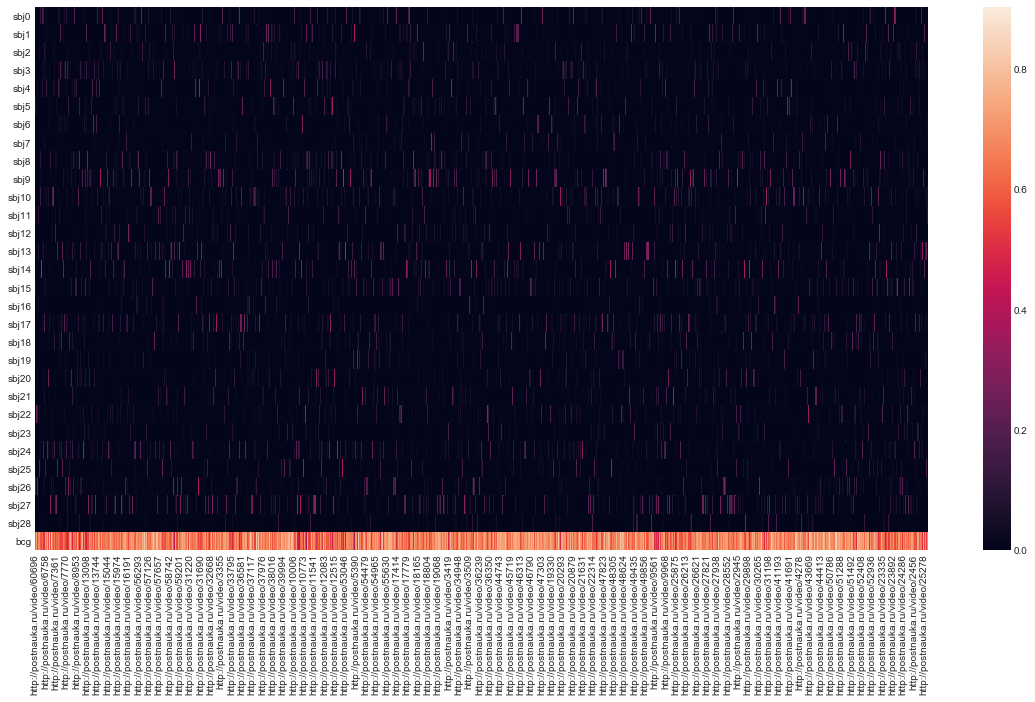

In [71]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.head(100))

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [72]:
# Ваш код
p_t = pd.DataFrame()
p_t['Topic_names'] = topic_names
p_t['Topic_labels'] = topic_labels
p_t['Topic_probabil'] = ((theta.sum(axis=1))/sum(theta.sum(axis=1))).values

In [73]:
p_t.sort_values(by='Topic_probabil', ascending=False)

,Topic_names,Topic_labels,Topic_probabil
29,bcg,Фоновая тема,0.658724
27,sbj27,Биология2,0.025206
9,sbj9,Физика,0.022604
14,sbj14,Космос2,0.019979
17,sbj17,Философия,0.016929
10,sbj10,ВОВ,0.016311
24,sbj24,История,0.015861
13,sbj13,Культура/Религия,0.015036
8,sbj8,Химия,0.014311
3,sbj3,Культура,0.014260


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

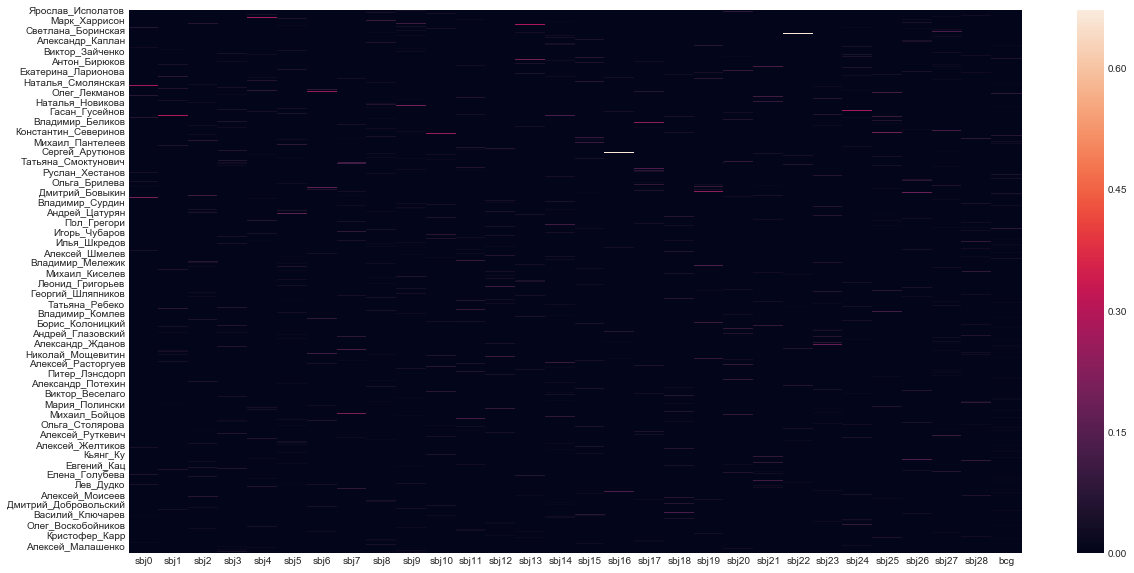

In [32]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [74]:
authors_frame = pd.DataFrame()
authors_frame['authors'] = phi_a.index
authors_frame['frequency'] = [sum(phi_a.iloc[i,:].values > 0.01) for i in range(phi_a.shape[0])]

In [75]:
authors_frame[authors_frame.frequency>=3]

,authors,frequency
184,Елена_Брызгалина,3
200,Андрей_Цатурян,3
229,Алина_Бодрова,3
342,Дмитрий_Лось,3


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [47]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [76]:
p_t_a = np.array([(np.array(phi_a.iloc[:,i].values)*np.array(p_t.loc[i,"Topic_probabil"]))/sum(np.array(phi_a.iloc[:,i].values)*np.array(p_t.loc[i,"Topic_probabil"])) for i in range(T)])

In [78]:
MDS_transformed_cos =  MDS(n_components=2, random_state=1,
                           dissimilarity="precomputed").fit_transform(pairwise_distances(p_t_a,
                                                                                         metric='cosine'),topic_labels)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

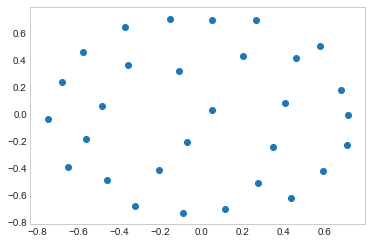

In [89]:
import matplotlib.cm as cm

#plt.figure(figsize=(20, 10))
plt.scatter(MDS_transformed_cos.T[0], MDS_transformed_cos.T[1]) 

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

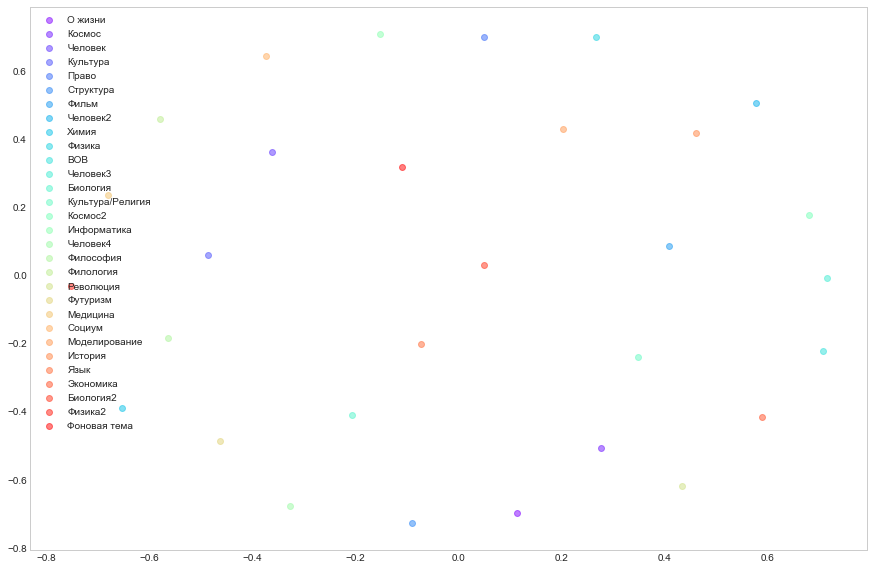

In [101]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

plt.figure(figsize=(15, 10))

for y, c in zip(topic_labels, colors):
    plt.scatter(MDS_transformed_cos[np.array(topic_labels)==y, 0], 
                MDS_transformed_cos[np.array(topic_labels)==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [103]:
p_d_t = np.array([theta.iloc[i,:]/sum(theta.iloc[i,:]) for i in range(theta.shape[0])])

In [141]:
most_probable_document_in_topic = pd.DataFrame()
most_probable_document_in_topic['Document'] = topic_labels
most_probable_document_in_topic['Most_probable_document'] = np.array([np.argmax(i) for i in p_d_t])

In [142]:
most_probable_document_in_topic

,Document,Most_probable_document
0,О жизни,92
1,Космос,619
2,Человек,753
3,Культура,529
4,Право,727
5,Структура,115
6,Фильм,519
7,Человек2,768
8,Химия,733
9,Физика,598


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [128]:
print ("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [102]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [153]:
for i, topic_name in enumerate(model_artm.topic_names):
    print (topic_labels[i])
    #display(HTML(u"<ul><li>topic_labels[i]</li><li>Пункт 2</li></ul>"))
    #print('\n')
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    if topic_name in tokens.keys():
        words = []
        for word in tokens[topic_name]:    
            words.append(word)
        print(','.join(words))
    print(theta.columns.values[most_probable_document_in_topic.loc[i,'Most_probable_document']])
    print('\n')

О жизни
церковь,власть,средневековый,император,русь,святой,римский,папа,князь,сага,король,александр,византийский,вера,рим
http://postnauka.ru/video/9299


Космос
планета,земля,атмосфера,солнце,солнечный,белый,газ,образовываться,карлик,вокруг,вода,поверхность,спутник,орбита,океан
http://postnauka.ru/video/53693


Человек
система,трудность,поведение,частота,двигаться,точность,искусственный,движение,относительность,тест,час,самка,задание,переход,часы
http://postnauka.ru/video/1856


Культура
культура,понятие,культурный,восприятие,сознание,феномен,личность,воспринимать,ощущение,чувство,повседневный,переживание,детство,этика,индивид
http://postnauka.ru/video/11034


Право
право,литература,искусство,литературный,юрист,писатель,должник,собственность,обязательство,владение,римский,произведение,исполнение,юридический,требование
http://postnauka.ru/video/17913


Структура
материал,структура,молекула,свойство,углерод,применение,поверхность,полимер,кристалл,металл,электронный,твердый,трехмерный,ал

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 